In [66]:
# Imports
import sys
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output
import datetime

import warnings
warnings.filterwarnings('ignore')

#networkx graph computing library
import networkx as nx

#opensourcemap networkx geopandas library
import osmnx as ox

# to create Point objects that can be used with the GeoDataFrame.contains(Point) boolean method
from shapely.geometry import Point

train_path = '../ny_dataset/train.csv'
man_filter_path = '../ny_dataset/contained_in_man.csv'

In [74]:
G_oms = ox.graph.graph_from_place('Manhattan, New York City', network_type='all_private', simplify=True, retain_all=False, truncate_by_edge=False, which_result=None, buffer_dist=None, clean_periphery=True, custom_filter=None)

In [88]:
# lots of useful stats about Manhattan map city

ox.stats.basic_stats(G_oms)

{'n': 33180,
 'm': 96127,
 'k_avg': 5.794273658830621,
 'edge_length_total': 3870317.581999933,
 'edge_length_avg': 40.262544155127415,
 'streets_per_node_avg': 3.37040385774563,
 'streets_per_node_counts': {0: 0,
  1: 2802,
  2: 54,
  3: 12701,
  4: 17324,
  5: 276,
  6: 20,
  7: 3},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.08444846292947558,
  2: 0.0016274864376130199,
  3: 0.382790837854129,
  4: 0.5221217600964436,
  5: 0.008318264014466547,
  6: 0.0006027727546714888,
  7: 9.041591320072333e-05},
 'intersection_count': 30378,
 'street_length_total': 2378343.5229999903,
 'street_segment_count': 55894,
 'street_length_avg': 42.5509629477223,
 'circuity_avg': 1.037627626920747,
 'self_loop_proportion': 0.001019787454825205}

In [134]:
# length in meters

edge_length_avg = 40.26

In [25]:
#taken from. https://github.com/gboeing/osmnx
def great_circle_vec(lat1, lng1, lat2, lng2, earth_radius=6371009):
    '''
    Function for finding distance between two points along sphere (Earth)
    
    parameters:
        lat1, lng1, lat2, lng2, earth_radius(ints): lat and long points used to convert into spherical coordinates
        
    returns:
        distance between input poin
    '''
    phi1 = np.deg2rad(90 - lat1)

    phi2 = np.deg2rad(90 - lat2)

    theta1 = np.deg2rad(lng1)
    theta2 = np.deg2rad(lng2)

    cos = (np.sin(phi1) * np.sin(phi2) * np.cos(theta1 - theta2) + np.cos(phi1) * np.cos(phi2))
    arc = np.arccos(cos)

    distance = arc * earth_radius
   
    return distance


def get_nearest_node(G, point, return_dist=False):
    '''
    Function for finding the nearest node to the given point
    
    parameters:
        G(networkx.classes.multidigraph.MultiDiGraph): networkX MultiDiGraph containing collection of nodes
        
        point(shapely.geometry.Point): point that will be placed on G to locate the nearest node in G
        
        return_dist(bool): Returns distance to nearest node if desired
        
    returns:
        nearest_node(shapely.geometry.Point)
        distances IF return_dist is True
    '''
    coords = np.array([[node, data['x'], data['y']] for node, data in G.nodes(data=True)])
    df = pd.DataFrame(coords, columns=['node', 'x', 'y']).set_index('node')
    df['reference_y'] = point[0]
    df['reference_x'] = point[1]

    distances = great_circle_vec(lat1=df['reference_y'],
                                 lng1=df['reference_x'],
                                 lat2=df['x'].astype('float'),
                                 lng2=df['y'].astype('float'))
  
    nearest_node = int(distances.idxmin())
  
    if return_dist:
        return nearest_node, distances.loc[nearest_node]
    else:
        return nearest_node

In [34]:
train = pd.read_csv(train_path)
manhattan_filter = pd.read_csv(man_filter_path, names=['in_man'])
train[manhattan_filter['in_man']]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373


In [124]:
train_man['id'].value_counts()

id3370460    1
id2717501    1
id0555574    1
id3999640    1
id1594755    1
            ..
id3256153    1
id2823835    1
id1235044    1
id0073269    1
id1782706    1
Name: id, Length: 1232404, dtype: int64

In [91]:
train_man.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
pickup_date           0
dtype: int64

# average passenger count

In [109]:
average_passenger_count = round(train_man['passenger_count'].mean(),2)
average_passenger_count

N = len(train_man)

one_passenger_p = len(train_man[train_man['passenger_count'] == 1])*100/N
two_passenger_p = len(train_man[train_man['passenger_count'] == 2])*100/N
three_passenger_p = len(train_man[train_man['passenger_count'] == 3])*100/N
four_passenger_p = len(train_man[train_man['passenger_count'] == 4])*100/N

print(f"Average passenger count: {average_passenger_count}")
print(f"{round(one_passenger_p, 2)}% of trips have 1 passenger")
print(f"{round(two_passenger_p,2)}%  of trips have 2 passenger")
print(f"{round(three_passenger_p,2)}%  of trips have 3 passenger")
print(f"{round(four_passenger_p,2)}%  of trips have 4 passenger")

Average passenger count: 1.66
71.08% of trips have 1 passenger
14.2%  of trips have 2 passenger
4.12%  of trips have 3 passenger
1.95%  of trips have 4 passenger


Clean the data to work with only points within Manhattan to work in smaller region

In [7]:
location = 'Manhattan, New York City'
manhattan_boundaries = ox.geocoder.geocode_to_gdf(location)
contained_in_man = []
done = 0
N = len(train)

for index, row in train.iterrows():
    pickup_point = Point(row['pickup_longitude'], row['pickup_latitude'])
    dropoff_point = Point(row['dropoff_longitude'], row['dropoff_latitude'])
    contained_in_man.append(manhattan_boundaries.contains(pickup_point) & manhattan_boundaries.contains(dropoff_point))
    clear_output(wait=True)
    done += 1
    print(f"PERCENT DONE: {(done/N)*100}%")  

PERCENT DONE: 100.0%


In [35]:
train_man = train[manhattan_filter['in_man']]

Find most popular day and work with that

In [42]:
train_man['pickup_date'] = train_man['pickup_datetime'].apply(lambda x: x[0:10])

In [53]:
train_man.groupby(['pickup_date']).size().sort_values()

pickup_date
2016-01-23    1325
2016-01-24    2847
2016-05-30    4274
2016-01-25    4899
2016-05-29    5135
              ... 
2016-03-04    7939
2016-02-13    8041
2016-04-16    8099
2016-03-05    8300
2016-04-09    8474
Length: 182, dtype: int64

Most active date in the DF is 2016-04-09, we'll take a sample from here

In [56]:
train_man_sample = train_man[train_man['pickup_date'] == '2016-04-09'].sort_values(['pickup_datetime'])

In [57]:
train_man_sample

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
20224,id3746230,1,2016-04-09 00:00:08,2016-04-09 00:10:22,1,-73.991249,40.734783,-73.975861,40.723957,Y,614,2016-04-09
882201,id2083050,2,2016-04-09 00:00:09,2016-04-09 00:25:21,5,-73.977501,40.759048,-74.004761,40.731110,N,1512,2016-04-09
171974,id0148168,1,2016-04-09 00:00:10,2016-04-09 00:09:41,3,-73.980103,40.742859,-73.980797,40.730698,N,571,2016-04-09
398351,id1534170,2,2016-04-09 00:01:02,2016-04-09 00:11:54,1,-73.988678,40.717751,-73.990372,40.723560,N,652,2016-04-09
359004,id2107058,2,2016-04-09 00:01:05,2016-04-09 00:37:40,1,-74.009132,40.716461,-73.981361,40.780788,N,2195,2016-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...
626334,id3517261,2,2016-04-09 23:59:45,2016-04-10 00:05:29,1,-73.987862,40.759769,-73.974556,40.762119,N,344,2016-04-09
343888,id1446867,1,2016-04-09 23:59:50,2016-04-10 00:07:59,1,-73.972633,40.780869,-73.967300,40.763279,N,489,2016-04-09
290342,id2438484,1,2016-04-09 23:59:58,2016-04-10 00:05:38,2,-73.994118,40.735252,-74.000870,40.735992,N,340,2016-04-09
525360,id3775068,2,2016-04-09 23:59:59,2016-04-10 00:14:01,2,-73.966949,40.768398,-73.993011,40.756760,N,842,2016-04-09


Make a list of time intervals of 5mins

My reasoning is that people are "busy"! Waiting more than 5 minutes for a ride seems to be counterproductive for todays apps like Uber and Lyft, at least in a busy city like New York

In [110]:
time_intervals = pd.date_range(start="2016-04-09 00:00:00", end = "2016-04-10 00:00:00", freq="5min")

In [111]:
time_intervals

DatetimeIndex(['2016-04-09 00:00:00', '2016-04-09 00:05:00',
               '2016-04-09 00:10:00', '2016-04-09 00:15:00',
               '2016-04-09 00:20:00', '2016-04-09 00:25:00',
               '2016-04-09 00:30:00', '2016-04-09 00:35:00',
               '2016-04-09 00:40:00', '2016-04-09 00:45:00',
               ...
               '2016-04-09 23:15:00', '2016-04-09 23:20:00',
               '2016-04-09 23:25:00', '2016-04-09 23:30:00',
               '2016-04-09 23:35:00', '2016-04-09 23:40:00',
               '2016-04-09 23:45:00', '2016-04-09 23:50:00',
               '2016-04-09 23:55:00', '2016-04-10 00:00:00'],
              dtype='datetime64[ns]', length=289, freq='5T')

# We want to test: during a given time window (say 15 min), what's the chance that two routes share a lot of road segments so that ride-sharing makes sense.

Examine average overlap within a 15min timeframe

In [112]:
start = str(time_intervals[0])
end = str(time_intervals[1])

data_within_range = train_man_sample[(start <= train_man_sample['pickup_datetime']) & (end >= train_man_sample['pickup_datetime'])]

In [113]:
data_within_range

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date
20224,id3746230,1,2016-04-09 00:00:08,2016-04-09 00:10:22,1,-73.991249,40.734783,-73.975861,40.723957,Y,614,2016-04-09
882201,id2083050,2,2016-04-09 00:00:09,2016-04-09 00:25:21,5,-73.977501,40.759048,-74.004761,40.731110,N,1512,2016-04-09
171974,id0148168,1,2016-04-09 00:00:10,2016-04-09 00:09:41,3,-73.980103,40.742859,-73.980797,40.730698,N,571,2016-04-09
398351,id1534170,2,2016-04-09 00:01:02,2016-04-09 00:11:54,1,-73.988678,40.717751,-73.990372,40.723560,N,652,2016-04-09
359004,id2107058,2,2016-04-09 00:01:05,2016-04-09 00:37:40,1,-74.009132,40.716461,-73.981361,40.780788,N,2195,2016-04-09
237110,id0137659,2,2016-04-09 00:01:17,2016-04-09 00:27:06,1,-74.003777,40.726040,-73.947571,40.771271,N,1549,2016-04-09
802852,id0596164,2,2016-04-09 00:01:53,2016-04-09 00:12:59,1,-73.983719,40.730160,-73.990921,40.718391,N,666,2016-04-09
699509,id1990441,1,2016-04-09 00:01:54,2016-04-09 00:05:15,1,-73.956367,40.778484,-73.961784,40.767258,N,201,2016-04-09
450308,id1338068,1,2016-04-09 00:01:54,2016-04-09 00:14:30,2,-73.993866,40.720886,-73.976036,40.740360,N,756,2016-04-09
442422,id3052326,2,2016-04-09 00:02:26,2016-04-09 00:14:00,5,-74.014801,40.709690,-73.994881,40.725052,N,694,2016-04-09


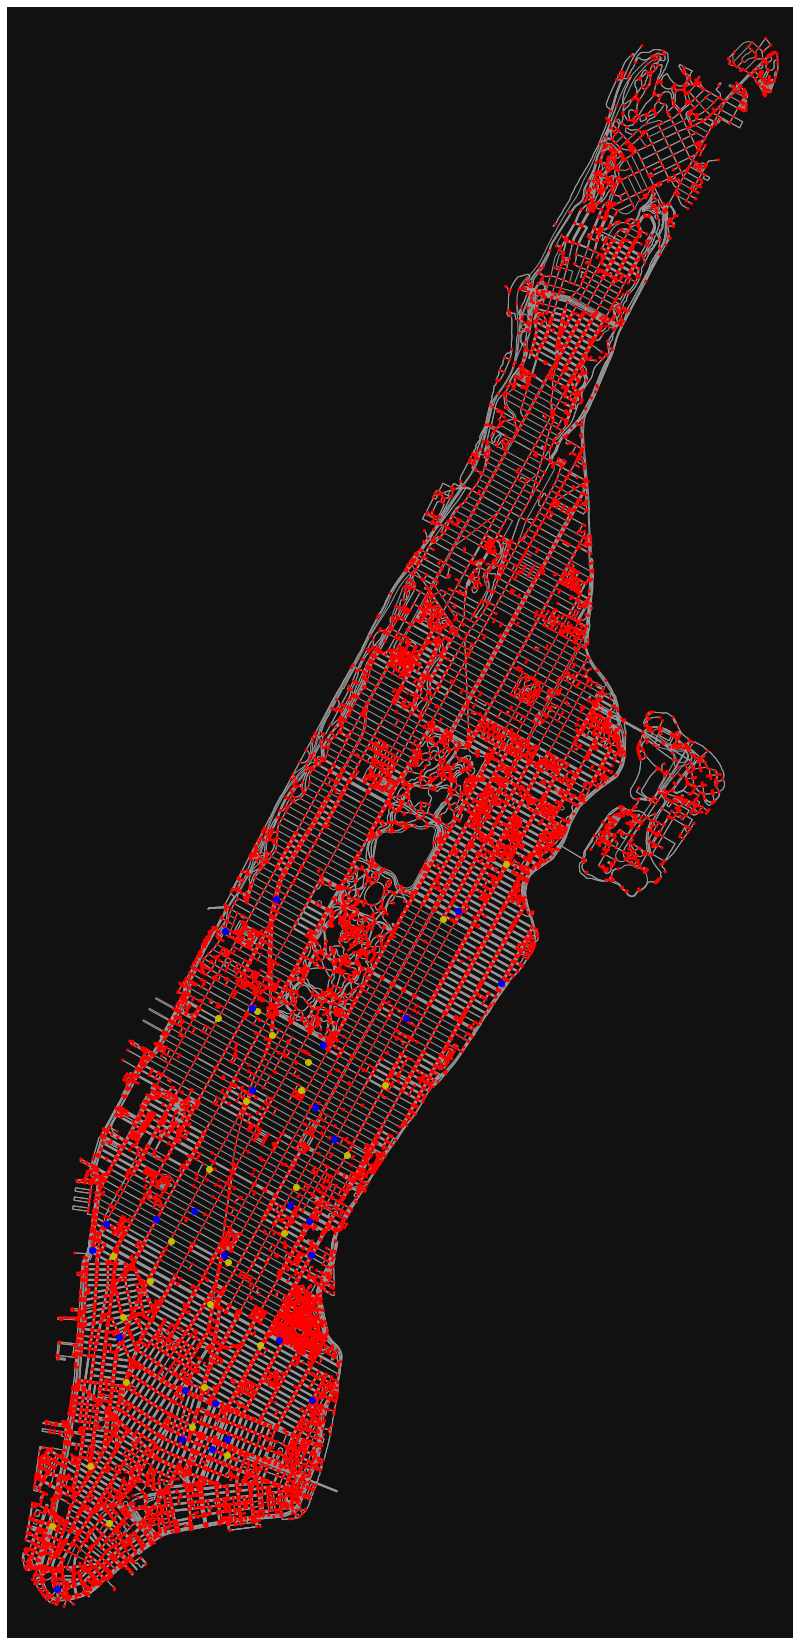

In [114]:
data_within_range_pickup_longs = data_within_range['pickup_longitude']
data_within_range_pickup_lats = data_within_range['pickup_latitude']
data_within_range_dropoff_longs = data_within_range['dropoff_longitude']
data_within_range_dropoff_lats = data_within_range['dropoff_latitude']

fig, ax = ox.plot.plot_graph(G_oms, figsize=(30, 30), node_color = 'r', node_size = 10, show=False, close=False)
ax.scatter(data_within_range_pickup_longs, data_within_range_pickup_lats, c='y')
ax.scatter(data_within_range_dropoff_longs, data_within_range_dropoff_lats, c='b')
plt.show()

In [149]:
# refactored from https://www.kaggle.com/usui113yst/basic-network-analysis-tutorial?select=manhatten.graphml
# using solely OSMNX packages

def find_shortest_routes(dataframe):
    """
    Parameters:
        dataframe: trip df with pickup and dropoff locations
    Returns:  
      shortest_routes: list of OSM graph nodes that constitute shortest paths from pickup to dropoff locations
      
    Extra notes:
        Added a percentage calculator since large datasets take a long while to process this information
    """
    shortest_routes = []
    finished = 0
    row_count = len(dataframe)
    for index, row in dataframe.iterrows():
        pick_point = (row['pickup_longitude'], row['pickup_latitude'])
        drop_point = (row['dropoff_longitude'], row['dropoff_latitude'])

        #below return the node id from G_oms of closest node
        pick_node = ox.distance.nearest_nodes(G_oms, pick_point[0], pick_point[1], return_dist=False)
        drop_node = ox.distance.nearest_nodes(G_oms, drop_point[0], drop_point[1], return_dist=False)

        try:
            routes = ox.distance.k_shortest_paths(G_oms, pick_node, drop_node, 3)
            shortest_routes.append(routes)
                #plot the shortest path on the graph
                #fig, ax = ox.plot_graph_route(G, route,fig_height=15, node_size=1)
        except:
            pass

        finished += 1

        clear_output(wait=True)
        print("PERCENTAGE DONE: ", (finished/row_count)*100, "%")
            
    return shortest_routes

In [150]:
shortest_routes_data_within_range = find_shortest_routes(data_within_range)
data_within_range['pp_to_dp'] = shortest_routes_data_within_range
data_within_range['len_pp_to_dp'] = data_within_range['pp_to_dp'].apply(lambda row: 0 if row is None else len(row))

PERCENTAGE DONE:  100.0 %


TypeError: object of type 'generator' has no len()

In [156]:
for route in shortest_routes_data_within_range:
    print(list(route))

[]
[[8231896473, 2567557320, 7465370993, 7465370992, 3314293720, 7465363218, 3314293718, 8841021136, 3314293716, 5296792747, 7465345748, 7465345747, 8231901007, 7465375816, 8231901008, 7465380416, 5854381582, 5854381561, 5854381570, 42432060, 5854381562, 7611187236, 7480301867, 7480301866, 5798966629, 7480301865, 7480301863, 5783028387, 42451665, 5783028393], [8231896473, 2567557320, 7465370993, 7465370992, 3314293720, 7465363218, 3314293718, 8841021136, 3314293716, 5296792747, 7465345748, 7465345747, 8231901007, 7465375816, 8231901008, 7465380416, 5854381582, 3314293714, 5854381570, 42432060, 5854381562, 7611187236, 7480301867, 7480301866, 5798966629, 7480301865, 7480301863, 5783028387, 42451665, 5783028393], [8231896473, 2567557320, 7465370993, 7465370992, 3314293720, 7465363218, 3314293718, 8841021136, 3314293716, 5296792747, 7465345748, 7465345747, 8231901007, 7465375816, 8231901008, 7465380416, 5854381582, 5854381561, 3314293703, 5854381573, 5854381562, 7611187236, 7480301867, 748

KeyboardInterrupt: 

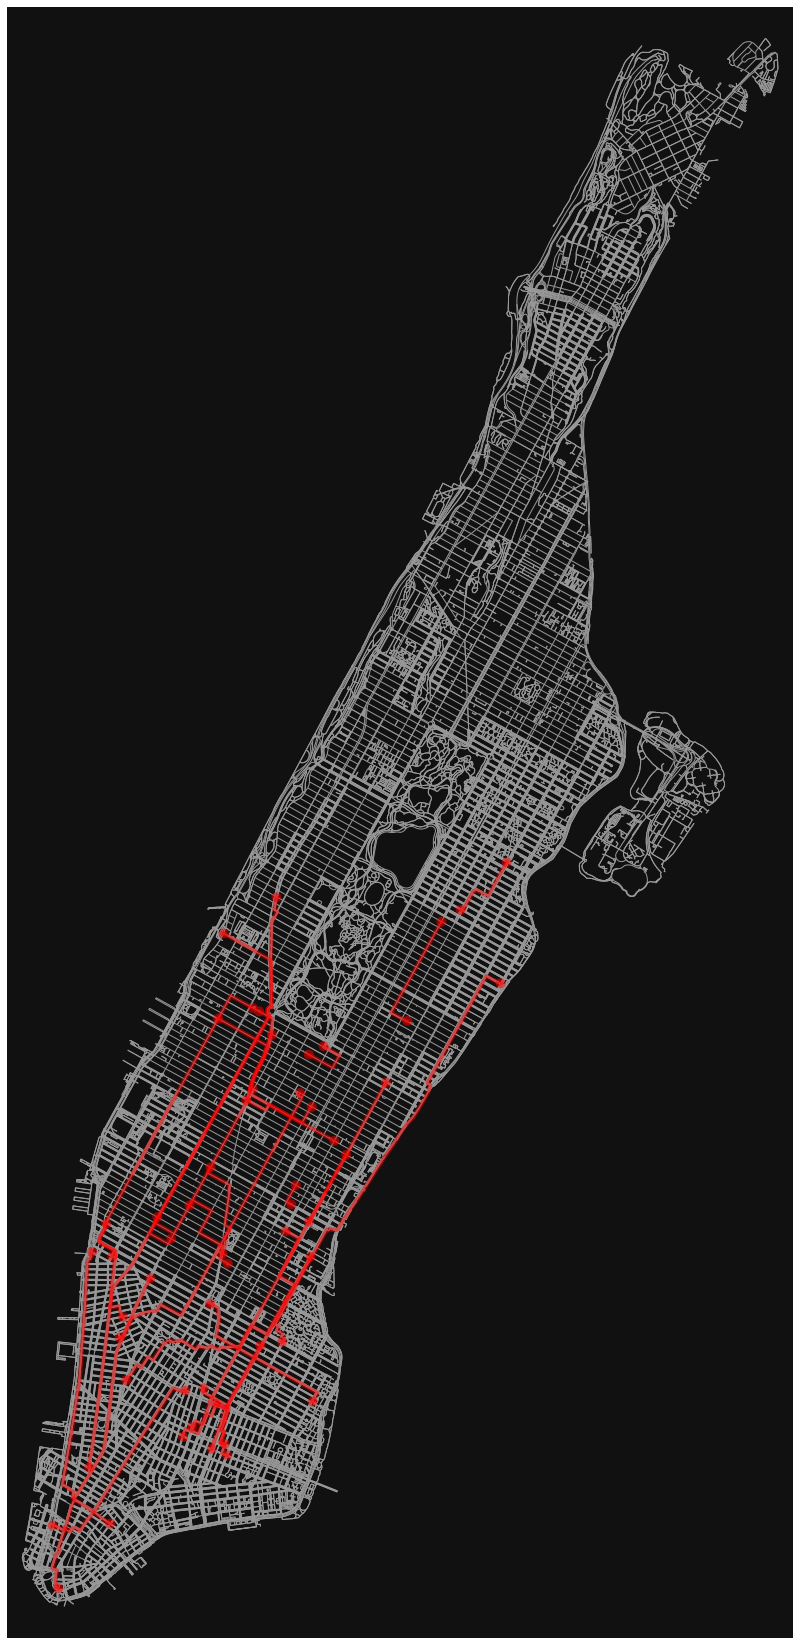

In [117]:
fig, ax = ox.plot_graph_routes(G_oms, list(data_within_range['pp_to_dp']), figsize=(30, 30), route_linewidth=6, node_size=0)

# Going to have different thresholds for min overlap for a ride to be shareable

50%, 40%, 30%, 20%

I'm going to use the route-agnostic protocol used in the Modeling and Prediction of Ride-Sharing Utilization Dynamics paper, on top of route overlap, it can be seen that a route overlap of one node means a crossing of routes, perpendicular to each other, which doesn't add to shareability. 

Rides that have similar start and end points are to be merged if passenger count permits

I'm going to assume a max passenger count of 3, being that some drivers don't allow front seat passengers, and if they do, the back seat can get easily overcrowded with 3 people in a 5 seat car

In [128]:
train_man = train_man[train_man['passenger_count'] <= 2]

In [123]:
data_within_range = data_within_range[data_within_range['passenger_count'] <= 2]

In [129]:
def overlap_matrix(df):
    """
    parameters:
        df(Pandas.DataFrame)
        
    returns:
        matrix(size x size): matrix with tuple values of (num_shared, average) at matrix[i][j]
            num_shared(int): count of intersecting nodes between row i and row j of df
            average: fractional average of shared nodes with respect to the lengs of the two row's paths
            
        overlaps(list(ints)): list of all the averages for visualization purposes
     """
    size = len(df)
    
    matrix = [[0]*size for row in range(size)]
    overlaps = []
    
    shareable = []

    finished = 0

    for row_ind in range(size):
        for col_ind in range(size):
            if row_ind != col_ind:
                path1 = df['pp_to_dp'].iloc[row_ind]
                path2 = df['pp_to_dp'].iloc[col_ind]

                if path1 is None or path2 is None:
                    average = 0
                    overlaps.append(0)
                    
                else:
                    path1_len = len(path1)
                    path2_len = len(path2)

                    shared_nodes = [node for node in path1 if node in path2]

                    num_shared = len(shared_nodes)

                    path1_overlap = (num_shared/path1_len)*100
                    path2_overlap = (num_shared/path2_len)*100
                    
                    if path1_overlap or path2_overlap >= 50:
                        pair = (df['id'].iloc[row_ind], df['id'].iloc[col_ind])
                        shareable.append(pair)
                    
                    average = 2*num_shared/(path1_len + path2_len)
                    
                    overlaps.append(round(average, 6))

                matrix[row_ind][col_ind] = (num_shared, average)

            finished += 1
            clear_output(wait=True)
            print("PERCENTAGE DONE: ", (finished/(size**2))*100, "%")
            
    return matrix, overlaps, shareable

In [130]:
matrix, overlaps, shareable = overlap_matrix(data_within_range)

PERCENTAGE DONE:  100.0 %


In [132]:
pd.DataFrame(matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0,"(0, 0.0)","(0, 0.0)","(1, 0.007272727272727273)","(1, 0.01834862385321101)","(0, 0.0)","(1, 0.011976047904191617)","(1, 0.009708737864077669)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
1,"(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(1, 0.023255813953488372)","(0, 0.0)","(1, 0.013888888888888888)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
2,"(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(7, 0.0472972972972973)","(0, 0.0)","(80, 0.47904191616766467)","(1, 0.007518796992481203)","(1, 0.006802721088435374)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(1, 0.007246376811594203)","(0, 0.0)"
3,"(1, 0.007272727272727273)","(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(2, 0.011904761904761904)","(1, 0.005333333333333333)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
4,"(1, 0.01834862385321101)","(1, 0.023255813953488372)","(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(6, 0.07058823529411765)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
5,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
6,"(1, 0.011976047904191617)","(1, 0.013888888888888888)","(0, 0.0)","(2, 0.011904761904761904)","(6, 0.07058823529411765)","(0, 0.0)",0,"(3, 0.02247191011235955)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
7,"(1, 0.009708737864077669)","(0, 0.0)","(0, 0.0)","(1, 0.005333333333333333)","(0, 0.0)","(0, 0.0)","(3, 0.02247191011235955)",0,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(27, 0.3)"
8,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(2, 0.05)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"
9,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)",0,"(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)","(0, 0.0)"


In [133]:
shareable

[('id3746230', 'id0137659'),
 ('id3746230', 'id0596164'),
 ('id3746230', 'id1338068'),
 ('id3746230', 'id3735664'),
 ('id1534170', 'id0596164'),
 ('id1534170', 'id1338068'),
 ('id2107058', 'id3608091'),
 ('id2107058', 'id2353300'),
 ('id2107058', 'id3222154'),
 ('id2107058', 'id1081216'),
 ('id2107058', 'id1057928'),
 ('id0137659', 'id3746230'),
 ('id0137659', 'id1338068'),
 ('id0137659', 'id3735664'),
 ('id0596164', 'id3746230'),
 ('id0596164', 'id1534170'),
 ('id0596164', 'id1338068'),
 ('id1338068', 'id3746230'),
 ('id1338068', 'id1534170'),
 ('id1338068', 'id0137659'),
 ('id1338068', 'id0596164'),
 ('id1338068', 'id3735664'),
 ('id3735664', 'id3746230'),
 ('id3735664', 'id0137659'),
 ('id3735664', 'id1338068'),
 ('id3735664', 'id1827411'),
 ('id1619401', 'id1081216'),
 ('id3608091', 'id2107058'),
 ('id3608091', 'id1196908'),
 ('id1196908', 'id3608091'),
 ('id1196908', 'id1057928'),
 ('id2353300', 'id2107058'),
 ('id2353300', 'id3222154'),
 ('id2353300', 'id1081216'),
 ('id2353300',

I need to think of more parameters to determine shareability, because what if two routes are similar but don't overlap because they are an edge or two away but parallel? This is one possibility of a shareable route, and I have a feeling there are more.

In [145]:
data_within_range['avg_speed'] = data_within_range['len_pp_to_dp']*edge_length_avg/data_within_range['trip_duration']

In [146]:
data_within_range

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pp_to_dp,len_pp_to_dp,avg_speed
20224,id3746230,1,2016-04-09 00:00:08,2016-04-09 00:10:22,1,-73.991249,40.734783,-73.975861,40.723957,Y,614,2016-04-09,"[4983147898, 7581217744, 7581217746, 719628477...",53,3.475212
398351,id1534170,2,2016-04-09 00:01:02,2016-04-09 00:11:54,1,-73.988678,40.717751,-73.990372,40.723560,N,652,2016-04-09,"[8231896473, 2567557320, 7465370993, 746537099...",30,1.852454
359004,id2107058,2,2016-04-09 00:01:05,2016-04-09 00:37:40,1,-74.009132,40.716461,-73.981361,40.780788,N,2195,2016-04-09,"[8304497527, 8304497528, 8304498508, 830449848...",236,4.328638
237110,id0137659,2,2016-04-09 00:01:17,2016-04-09 00:27:06,1,-74.003777,40.726040,-73.947571,40.771271,N,1549,2016-04-09,"[8307641858, 8307641857, 6491645895, 830764185...",222,5.769994
802852,id0596164,2,2016-04-09 00:01:53,2016-04-09 00:12:59,1,-73.983719,40.730160,-73.990921,40.718391,N,666,2016-04-09,"[8309479585, 8309479591, 8309479586, 830947927...",56,3.385225
699509,id1990441,1,2016-04-09 00:01:54,2016-04-09 00:05:15,1,-73.956367,40.778484,-73.961784,40.767258,N,201,2016-04-09,"[42435509, 42447126, 42439399, 42447115, 42438...",23,4.606866
450308,id1338068,1,2016-04-09 00:01:54,2016-04-09 00:14:30,2,-73.993866,40.720886,-73.976036,40.740360,N,756,2016-04-09,"[8231909725, 8231909723, 8231909720, 823190972...",114,6.070952
1185411,id3735664,1,2016-04-09 00:02:32,2016-04-09 00:26:39,1,-73.965034,40.759678,-73.995377,40.719551,N,1447,2016-04-09,"[6188803954, 42432861, 42442960, 42442959, 424...",153,4.256932
485442,id1619401,2,2016-04-09 00:02:35,2016-04-09 00:11:42,1,-73.988426,40.739613,-73.993515,40.745354,N,547,2016-04-09,"[5481897719, 4276517116, 42428192, 8264671706,...",22,1.619232
142470,id3045845,1,2016-04-09 00:02:49,2016-04-09 00:15:34,1,-74.000229,40.737495,-74.014061,40.702534,N,765,2016-04-09,"[8309479755, 8262308355, 8262308356, 826230835...",170,8.946667
